Copyright 2023 ICUBE Laboratory, University of Strasbourg

License: Apache License, Version 2.0

Author: Thibault Poignonec (thibault.poignonec@gmail.com)

Created on Tue Oct 2023

# Generate some data

In [2]:
import numpy as np
import os
from copy import deepcopy
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

# 1DOF backlash models (2 to 4 parameters per element)
from backlash_simulation_examples.models.model_1dof_backlash import eval_1DOF_backlash

# Generate some data
def generate_dummy_data(dt, dof, theta, std_noise_q = 0):
    t_max = 50.0
    t = np.arange(0.0, t_max, dt)

    # Generate smooth q data
    q_no_noise_raw = 2*np.sin(np.pi/17*t) + 5*np.sin(np.pi/2*t)*np.exp(-t/10) + 3*np.sin(np.pi/4*t) - 3*np.sin(np.pi/6*t)
    # Add a "pause"
    dq__no_noise_raw = np.diff(q_no_noise_raw)
    if False : # set to true to add a pause
        dq__no_noise_raw[1400:4500].fill(0)
    q_no_noise = np.hstack((q_no_noise_raw[0], dq__no_noise_raw)).cumsum()
    # Add gaussian noise (opt.)
    noise_q = None
    if std_noise_q > 0 :
        noise_q = np.random.normal(0,std_noise_q,t.shape[0])
        q_data = (q_no_noise + noise_q).reshape((-1,1))
    else :
        q_data = q_no_noise.reshape((-1,1))
    # normalize between -1 and 1
    q_data = q_data - np.min(q_data)
    q_data = q_data/np.max(q_data) * 2 -1

    c_data = np.zeros(q_data.shape)

    x_data = np.zeros((t.shape[0], 1 + theta.shape[0]))
    x_data[0,:] = np.append(0, theta)

    x_k_1 = None
    for k in range(1,t.shape[0]):
        x_k_1 = x_data[k-1,:].copy()
        q_k = q_data[k,0]
        q_k_1 = q_data[k-1,:]
        # Process backlash
        f_1, F_1, H_c_1, obserbable_1 = eval_1DOF_backlash(x_k_1, q_k, q_k_1, dof=dof)
        # Compute output
        x_k = f_1(x_k_1, q_k)
        x_data[k,:] = x_k.copy()
    # Retropropagate to the initial state to avoid discontinuity
    x_data[0,:]= x_data[1,:].copy()
    z_data = x_data[:,0].reshape((-1,1)) # z_k = c_k
    return t, q_data, x_data, z_data

In [3]:
dt = 0.02 # Sampling period
theta_star = np.array([-.15,0.25, 1.15, 0.9])
std_noise_q = 0.0
std_noise_z = 0.02
t, q_data, x_data, z_no_noise_data = generate_dummy_data(dt, dof = 4, theta = theta_star, std_noise_q = std_noise_q)
noise_measurements = np.random.normal(0,std_noise_z, z_no_noise_data.shape[0]*z_no_noise_data.shape[1]).reshape(z_no_noise_data.shape)
z_data = z_no_noise_data + noise_measurements

# Plot generated data

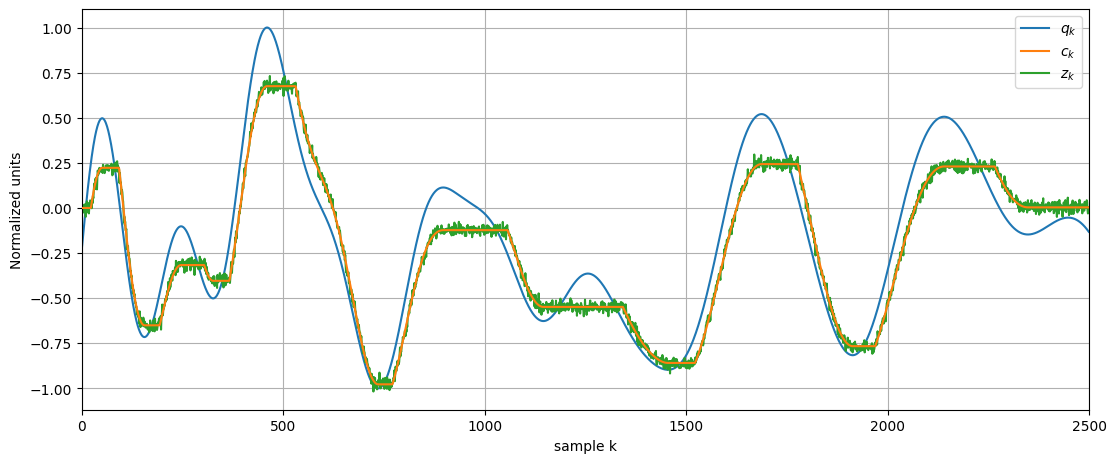

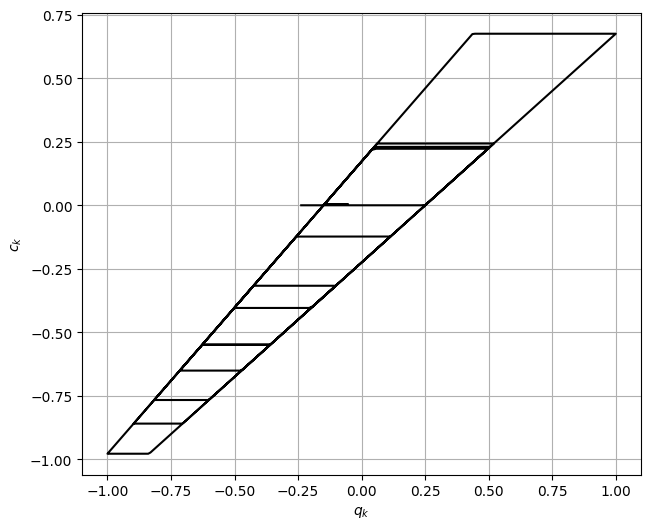

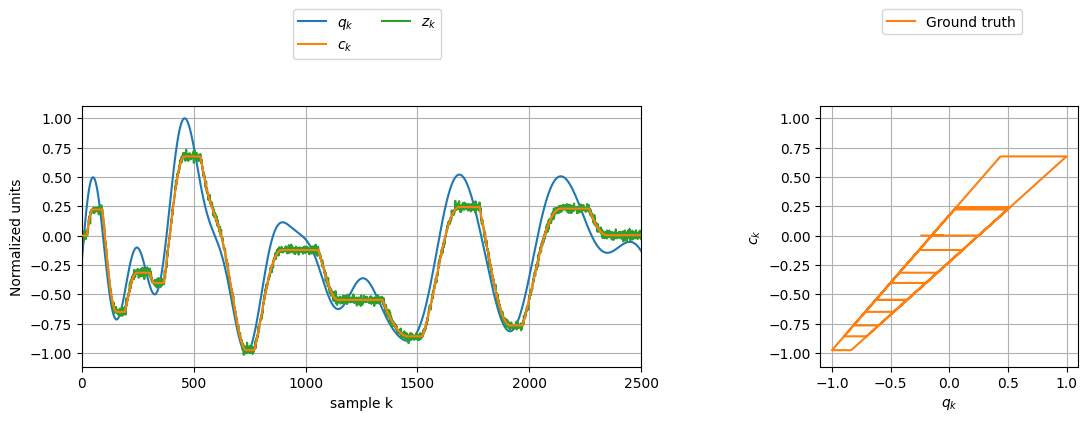

In [4]:
# Plot input data and baseline perf.
fig, ax = plt.subplots(
    1,1,
    figsize=(
        plt.rcParams["figure.figsize"][0],
        0.4*plt.rcParams["figure.figsize"][0]
    )
)
ax.plot( q_data[:,0], label = r'$q_k$')
ax.plot( x_data[:,0], label = r'$c_k$', zorder=10) # On top !!!
ax.plot( z_data[:,0], label = r'$z_k$')

ax.set_xlim(0,t.shape[0])

ax.set_xlabel('sample k')
ax.set_ylabel('Normalized units')
ax.grid()
ax.legend(frameon=True)
plt.show()

fig = plt.figure()
ax = plt.axes()
ax.plot(q_data[:,0], x_data[:,0], 'k')
ax.set_xlabel(r'$q_k$')
ax.set_ylabel(r'$c_k$')
ax.grid()
ax.set_aspect('equal')
plt.show()

fig, (ax1, ax2) = plt.subplots(
    1,2,
    figsize=(plt.rcParams["figure.figsize"][0], 0.26 * plt.rcParams["figure.figsize"][0]),
    gridspec_kw={'width_ratios': [5,2.5], "wspace":0.4}
)

ax1.plot( q_data[:,0], label = r'$q_k$')
ax1.plot( x_data[:,0], label = r'$c_k$', zorder=10) # On top !!!
ax1.plot( z_data[:,0], label = r'$z_k$')
ax1.set_xlim(0,t.shape[0])
ax1.set_xlabel('sample k')
ax1.set_ylabel('Normalized units')
ax1.grid()
ax1.legend(ncol=2, frameon=True, loc='upper center', bbox_to_anchor=(0.51, 1.4))
ax2.sharey(ax1)
ax2.plot([], [], label="_")
ax2.plot(q_data[:,0], x_data[:,0], label="Ground truth")
ax2.legend(frameon=True, loc='upper center', bbox_to_anchor=(0.51, 1.4))
#ax2.set_title(r'$\mathcal{B}(\cdot)$')
ax2.set_xlabel(r'$q_k$')
ax2.set_ylabel(r'$c_k$')
ax2.grid()
ax2.set_aspect('equal')
plt.show()